**Utility Analysis**


Questions:
1. Which positions are effective smoke positions for round wins, on either side? 

    a. Which smokes and flashes thrown by terrorists before the bomb is planted result in a bomb plant? Which smokes thrown by CTs after a bomb plant result in a defusal? 

    b. What grenades in general are effective in winning the round? To study this, we can use regression to calculate the marginal impact of each grenade.

    c. What groups of smokes are most effective?
    
2. Which nade positions do the most damage on average/nade damage heatmap
4. Do any of these conclusions change based on round type?
 

In [ ]:
grenade_df = pd.read_csv(r"C:\Users\yoges\Downloads\archive (4)\esea_master_grenades_demos.part1.csv")
grenade_df = grenade_df[['file', 'round', 'seconds', 'att_side', 'vic_side', 'is_bomb_planted', 'bomb_site', 'nade', 'nade_land_x', 'nade_land_y', 'att_pos_x', 'att_pos_y']]
meta_df = pd.read_csv(r"C:\Users\yoges\Downloads\archive (4)\esea_meta_demos.part1.csv")
grenade_df = pd.merge(grenade_df, meta_df, how='left', left_on=['file','round'], right_on = ['file','round'])
grenade_df['seconds'] -= grenade_df['start_seconds']

grenade_df.set_index(['file', 'round'], inplace=True)

map_df = pd.read_csv(r"C:\Users\yoges\Downloads\archive (4)\map_data.csv")
map_df = map_df.rename( columns={'Unnamed: 0':'map_name'}).set_index('map_name')
print(map_df)

print(grenade_df.info())
print(grenade_df.head())


             EndX  EndY  ResX  ResY  StartX  StartY
map_name                                           
de_cache     3752  3187  1024  1024   -2031   -2240
de_cbble     2282  3032  1024  1024   -3819   -3073
de_dust2     2127  3455  1024  1024   -2486   -1150
de_inferno   2797  3800  1024  1024   -1960   -1062
de_mirage    1912  1682  1024  1024   -3217   -3401
de_overpass   503  1740  1024  1024   -4820   -3591
de_train     2262  2447  1024  1024   -2436   -2469
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2990060 entries, (esea_match_13770997.dem, 1) to (esea_match_13793043.dem, 18)
Data columns (total 18 columns):
seconds            float64
att_side           object
vic_side           object
is_bomb_planted    bool
bomb_site          object
nade               object
nade_land_x        float64
nade_land_y        float64
att_pos_x          float64
att_pos_y          float64
map                object
start_seconds      float64
end_seconds        float64
winner_team        object
w

In [ ]:
from sklearn.cluster import AgglomerativeClustering, DBSCAN
from sklearn.neighbors.nearest_centroid import NearestCentroid
from time import time
from sklearn.linear_model import LogisticRegression

#Convert map coordinates to image coordinates, from Bill Freeman's analysis
def pointx_to_resolutionx(xinput,startX=-3217,endX=1912,resX=1024):
    sizeX = endX - startX
    if startX < 0:
        xinput += startX * (-1.0)
    else:
        xinput += startX
    xoutput = float((xinput / abs(sizeX)) * resX);
    return xoutput

def pointy_to_resolutiony(yinput,startY=-3401,endY=1682,resY=1024):
    sizeY=endY-startY
    if startY < 0:
        yinput += startY *(-1.0)
    else:
        yinput += startY
    youtput = float((yinput / abs(sizeY)) * resY);
    return resY-youtput

#grenade_df['att_pos_x'] = grenade_df['att_pos_x'].apply(pointx_to_resolutionx)
#grenade_df['att_pos_y'] = grenade_df['att_pos_y'].apply(pointy_to_resolutiony)

def cluster_utility(grenade_df, max_nades_to_process=-1, nade_types = ['Smoke', 'HE', 'Flash'], teams = ['Terrorist', 'CounterTerrorist'], map_name='de_mirage', planted=False):
    """
    Given a dataframe of grenade usage, clusters the grenades into the most common spots, and plots the results.
    """
    # Create graphics
    fig, axs = plt.subplots(len(nade_types), len(teams), figsize=(25,25))
    map_filenames = {map_name: f'/yoges/downloads/input/csgo-matchmaking-damage/{map_name}.png' for map_name in grenade_df['map'].unique()}
    im = plt.imread(map_filenames[map_name])
    
    # Preprocess data on map of interest
    t_mirage_df = grenade_df[grenade_df['map'] == map_name]
    map_info = map_df.loc[map_name]
    t_mirage_df['cluster'] = None

    if planted is not None:
        t_mirage_df = t_mirage_df[t_mirage_df['is_bomb_planted'] == planted]
    
    
    # For each nade type and team, we will compute clusters and create a plot
    for i, nade_type in enumerate(nade_types):
        for j, team in enumerate(teams):
            before_time = time()
            t_mirage_nade_df = t_mirage_df[(t_mirage_df.nade==nade_type) & (t_mirage_df.att_side==team)]
            # Correct location
            t_mirage_nade_df['att_pos_y'] = t_mirage_nade_df['att_pos_y'].apply(pointy_to_resolutiony, args=(map_info['StartY'], map_info['EndY'], map_info['ResY']))
            t_mirage_nade_df['att_pos_x'] = t_mirage_nade_df['att_pos_x'].apply(pointx_to_resolutionx, args=(map_info['StartX'], map_info['EndX'], map_info['ResX']))
            t_mirage_nade_df['nade_land_y'] = t_mirage_nade_df['nade_land_y'].apply(pointy_to_resolutiony, args=(map_info['StartY'], map_info['EndY'], map_info['ResY']))
            t_mirage_nade_df['nade_land_x'] = t_mirage_nade_df['nade_land_x'].apply(pointx_to_resolutionx, args=(map_info['StartX'], map_info['EndX'], map_info['ResX']))
            # Determine how many points we will use from the data
            available_datapoints = len(t_mirage_nade_df)
            num_nades = max_nades_to_process
            if max_nades_to_process < 0:
                num_nades = available_datapoints
            num_nades = min(num_nades, available_datapoints)
            print(f"Using {num_nades}/{available_datapoints} available datapoints in {team} {nade_type}")
            t_mirage_nade_df = t_mirage_nade_df[:num_nades]
            ### Cluster into common smoke positions
            cluster = DBSCAN(eps=8, min_samples=num_nades/350, metric='euclidean', metric_params=None, algorithm='auto', leaf_size=30, p=None, n_jobs=None)
            smoke_pts = pd.concat([t_mirage_nade_df['nade_land_x'], t_mirage_nade_df['nade_land_y']], axis=1)
            cluster.fit(smoke_pts)
            t_mirage_nade_df['cluster'] = cluster.labels_
            ### Find centroids of clusters
            centroids = NearestCentroid()
            centroids.fit(smoke_pts, cluster.labels_)
            nade_clusters = centroids.centroids_
            
            # Calculate distance to centroid
            def distance_to_centroid(row):
                if row['cluster'] == -1:
                    return np.nan
                centroid = nade_clusters[row['cluster']+1]
                return math.sqrt((row['nade_land_x'] - centroid[0]) ** 2 + (row['nade_land_y'] - centroid[1]) ** 2)
            #t_mirage_nade_df['distance_to_centroid'] = t_mirage_nade_df.apply(distance_to_centroid, axis=1)
            
            # Plot smokes and clusters
            axs[i, j].set_title(f"{map_name} {team} {nade_type}s")
            axs[i, j].set_xlim(0, 1000)
            axs[i, j].set_ylim(1000, 0)
            t = axs[i, j].imshow(im)
            # Create map from clusters to color pallete
            color_labels = np.unique(cluster.labels_)
            rgb_values = sns.color_palette("Set2", color_labels.shape[0])
            color_map = dict(zip(color_labels, rgb_values))
            color_map[-1] = (0, 0, 0)

            # Plot! Uncomment one of the following to plot clusters, distance to centroid, or winning side
            #axs[i, j].scatter(t_mirage_nade_df['nade_land_x'], t_mirage_nade_df['nade_land_y'],alpha=2500/num_nades,c=t_mirage_nade_df['cluster'].map(color_map), marker='.')
            #axs[i, j].scatter(t_mirage_nade_df['nade_land_x'], t_mirage_nade_df['nade_land_y'],alpha=2500/num_nades,c=t_mirage_nade_df['distance_to_centroid'], marker='.', cmap=plt.cm.autumn)
            axs[i, j].scatter(t_mirage_nade_df['nade_land_x'], t_mirage_nade_df['nade_land_y'],alpha=2500/num_nades,c=(t_mirage_nade_df['winner_side'] == team).map({True: (1, 0, 0), False: (0, 0, 1)}), marker='.', cmap=plt.get_cmap('plasma'))
            
            axs[i, j].scatter(nade_clusters[:, 0], nade_clusters[:, 1], alpha=1,c='yellow')
            for k, pos in enumerate(zip(nade_clusters[:, 0], nade_clusters[:, 1])):
                print(f"{k}: {pos}")
                axs[i, j].annotate(str(k), pos, color='white', fontsize=15)

            # Collect our results
            t_mirage_df = t_mirage_df[(t_mirage_df.nade!=nade_type) | (t_mirage_df.att_side!=team)]
            t_mirage_df = t_mirage_df.append(t_mirage_nade_df)
            elapsed_time = time() - before_time
            print(f"Clustering took {elapsed_time} seconds")
            # Save the data
            n_points = 10000
            print(t_mirage_nade_df.columns)
            t_mirage_nade_df = t_mirage_nade_df.reset_index()
            t_mirage_nade_df["file_round"] = t_mirage_nade_df["file"] + t_mirage_nade_df["round"].astype(str)
            t_mirage_nade_df = t_mirage_nade_df[['file_round', 'seconds', 'att_side', 'bomb_site', 'nade_land_x', 'nade_land_y', 'cluster', 'winner_side']]
            t_mirage_nade_df.sample(n_points).to_csv(f'{map_name}_{team}_{nade_type}_{n_points}_locs.csv')
    print( t_mirage_df.loc[("esea_match_13792436.dem", 10)])
    t_mirage_df.loc[("esea_match_13792436.dem", 9)].to_csv(f'{map_name}_example_round.csv')
    return t_mirage_df

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/

Using 130000/138076 available datapoints in Terrorist Smoke
0: (460.60453963857896, 482.5465210897583)
1: (412.3298404342493, 465.0879773196342)
2: (594.1348962831612, 437.70165639992337)
3: (503.85317900913157, 466.4187217123363)
4: (461.57092146371923, 821.4604049753945)
5: (508.98032421878486, 668.6863766358791)
6: (551.5906758904342, 662.55018895477)
7: (481.4582000827734, 371.36782348609614)
8: (508.20644838820425, 436.06999297726634)
9: (465.91277700754705, 638.3530699633751)
10: (584.0983177827683, 665.6709922480243)
11: (642.752429216286, 757.4139033688963)
12: (177.48183569981444, 236.90939804463326)
13: (642.266301626938, 338.8538899582534)
14: (510.6916372397248, 549.2660283095794)
15: (641.1690583051146, 426.9816344049395)
16: (237.5992573747353, 188.7227912235143)
17: (509.10720001313337, 599.9922851693462)
18: (640.878860942259, 665.7438721081895)
19: (510.64444858226653, 520.9945314208012)
20: (554.0947872545597, 754.3580200406863)
21: (256.7537396025694, 387.74938000406

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/

Using 125090/125090 available datapoints in CounterTerrorist Smoke
0: (509.174594526392, 486.30009677649537)
1: (691.0757119853009, 645.2687203884326)
2: (348.327213237265, 190.2759877681487)
3: (654.6633691210122, 797.1039432604321)
4: (512.6484926640824, 504.9327862881024)
5: (530.7295880104438, 425.71056588813275)
6: (509.0156918913646, 590.280034443395)
7: (421.83145363201083, 465.4107705370783)
8: (642.2710079937638, 338.84871139091257)
9: (741.638137578634, 672.2234900649223)
10: (446.73915708392127, 432.7915029091139)
Clustering took 20.421295166015625 seconds
Index(['seconds', 'att_side', 'vic_side', 'is_bomb_planted', 'bomb_site',
       'nade', 'nade_land_x', 'nade_land_y', 'att_pos_x', 'att_pos_y', 'map',
       'start_seconds', 'end_seconds', 'winner_team', 'winner_side',
       'round_type', 'ct_eq_val', 't_eq_val', 'cluster'],
      dtype='object')


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/

Using 67009/67009 available datapoints in Terrorist HE
0: (476.4952040501813, 533.9508360678964)
1: (441.9878291629042, 280.98290857632935)
2: (511.05128870873153, 519.7213431722008)
3: (472.44918185833154, 382.3752352949014)
4: (417.5062979826527, 473.6978610056119)
5: (642.271007993764, 338.84871139091234)
6: (475.7145299032565, 641.8900323244904)
7: (395.45977489363935, 589.7512378803111)
8: (326.53410588493296, 226.513373086683)
9: (185.09714440665007, 183.71033156409547)
10: (662.7293793542447, 741.7952636053284)
11: (495.7130094102153, 578.3020545891308)
12: (480.98553104666195, 310.5562828202224)
13: (435.3612959248221, 838.6001186121621)
14: (416.1165416205559, 533.8667634340375)
15: (485.9601879179864, 530.8730407763029)
16: (718.0294805089964, 652.6497191886369)
17: (239.31243959079742, 183.9679175574228)
18: (491.61030212330144, 682.4799720672154)
19: (647.2869604334622, 662.4296885203071)
20: (106.22145150936225, 180.6569574157328)
21: (492.6201585803256, 771.2229455343188)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/

Using 119444/119444 available datapoints in CounterTerrorist HE
0: (526.7938865057625, 482.5224530898691)
1: (720.8565193264894, 652.2786234647282)
2: (385.62121460601986, 190.5794617794744)
3: (692.4165820694443, 400.3151796174876)
4: (668.7645553027205, 805.3051067595944)
5: (446.94898812834526, 439.39113517864723)
6: (733.1246476315935, 475.21878255603934)
Clustering took 13.639228105545044 seconds
Index(['seconds', 'att_side', 'vic_side', 'is_bomb_planted', 'bomb_site',
       'nade', 'nade_land_x', 'nade_land_y', 'att_pos_x', 'att_pos_y', 'map',
       'start_seconds', 'end_seconds', 'winner_team', 'winner_side',
       'round_type', 'ct_eq_val', 't_eq_val', 'cluster'],
      dtype='object')


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/

Using 130000/142572 available datapoints in Terrorist Flash
0: (544.6160469844984, 498.2788684831725)
1: (439.6441947882741, 269.71695283097193)
2: (638.8875993040965, 668.4545202398721)
3: (465.0599450428141, 643.0467815895466)
4: (297.29897487434295, 236.3272041633085)
5: (485.94554427834186, 359.10266219461494)
6: (666.9093771222687, 439.56905950773086)
7: (656.6839140943777, 762.8215717631583)
8: (465.70968997791294, 393.43585883579823)
9: (642.2631142547293, 338.9150961557726)
10: (509.05599706040255, 512.5544858060379)
11: (696.3283078307599, 503.99048681923)
12: (305.3577795281732, 196.67748941963401)
Clustering took 12.049920082092285 seconds
Index(['seconds', 'att_side', 'vic_side', 'is_bomb_planted', 'bomb_site',
       'nade', 'nade_land_x', 'nade_land_y', 'att_pos_x', 'att_pos_y', 'map',
       'start_seconds', 'end_seconds', 'winner_team', 'winner_side',
       'round_type', 'ct_eq_val', 't_eq_val', 'cluster'],
      dtype='object')


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/

Using 105205/105205 available datapoints in CounterTerrorist Flash
0: (528.6883454281619, 542.2085330930119)
1: (664.2111076080345, 807.4520364936415)
2: (478.21229931884534, 467.0863199574965)
3: (704.997979138596, 652.9237039784283)
4: (648.2165565848602, 702.1150083337077)
5: (328.69687267488666, 187.5825093522068)
6: (440.4541921283684, 253.86357452179874)
7: (642.2111205526851, 338.86328656038745)
8: (624.0602807407313, 734.8682724905187)
9: (464.25995950173257, 401.28065575212275)
Clustering took 8.768567562103271 seconds
Index(['seconds', 'att_side', 'vic_side', 'is_bomb_planted', 'bomb_site',
       'nade', 'nade_land_x', 'nade_land_y', 'att_pos_x', 'att_pos_y', 'map',
       'start_seconds', 'end_seconds', 'winner_team', 'winner_side',
       'round_type', 'ct_eq_val', 't_eq_val', 'cluster'],
      dtype='object')


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:115: PerformanceWarning: indexing past lexsort depth may impact performance.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:116: PerformanceWarning: indexing past lexsort depth may impact performance.


                               seconds          att_side vic_side  \
file                    round                                       
esea_match_13792436.dem 10     19.0020  CounterTerrorist      NaN   
                        10     19.4559  CounterTerrorist      NaN   
                        10     23.4159  CounterTerrorist      NaN   
                        10     23.7290  CounterTerrorist      NaN   
                        10     21.8037  CounterTerrorist      NaN   
                        10     46.8006  CounterTerrorist      NaN   
                        10     27.4699  CounterTerrorist      NaN   

                               is_bomb_planted bomb_site        nade  \
file                    round                                          
esea_match_13792436.dem 10               False       NaN  Incendiary   
                        10               False       NaN  Incendiary   
                        10               False       NaN       Smoke   
                  

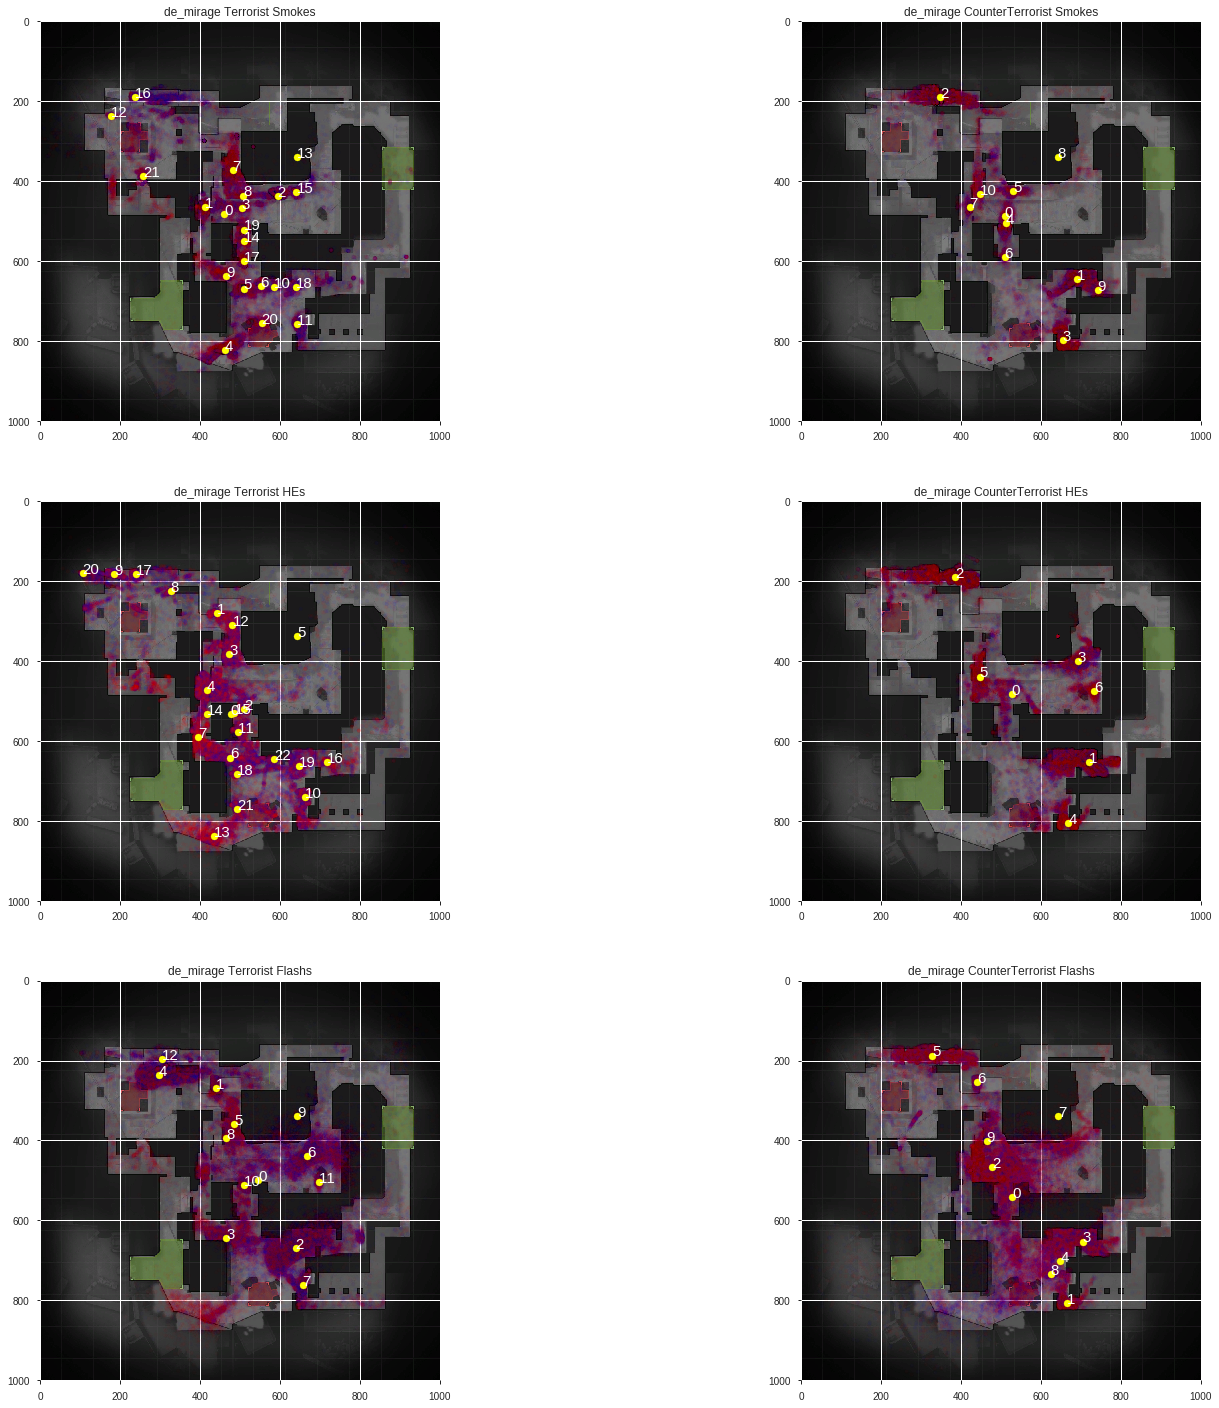

In [4]:
from IPython.display import FileLink
map_name = 'de_mirage'
clustered_nade_df = cluster_utility(grenade_df, map_name=map_name, max_nades_to_process = 130000)

In [5]:
dat =  clustered_nade_df.loc[("esea_match_13779770.dem", 6)]
print(dat)
fname = f'{map_name}_example_round.csv'
clustered_nade_df.loc[("esea_match_13779770.dem", 6)].to_csv(fname)
FileLink(fname)

                               seconds          att_side vic_side  \
file                    round                                       
esea_match_13779770.dem 6      51.1712         Terrorist      NaN   
                        6      24.2002         Terrorist      NaN   
                        6      19.8486  CounterTerrorist      NaN   
                        6      26.2039  CounterTerrorist      NaN   
                        6      33.4984  CounterTerrorist      NaN   
                        6      44.7846         Terrorist      NaN   
                        6      27.6753  CounterTerrorist      NaN   
                        6      21.6644  CounterTerrorist      NaN   
                        6      36.1438  CounterTerrorist      NaN   
                        6      41.0904  CounterTerrorist      NaN   

                               is_bomb_planted bomb_site     nade  \
file                    round                                       
esea_match_13779770.dem 6        

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: PerformanceWarning: indexing past lexsort depth may impact performance.
  after removing the cwd from sys.path.


/kaggle/working/de_mirage_example_round.csv

Calculating for de_mirage...


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/

Using 130000/138076 available datapoints in Terrorist Smoke
0: (460.60453963857896, 482.5465210897583)
1: (412.3298404342493, 465.0879773196342)
2: (594.1348962831612, 437.70165639992337)
3: (503.85317900913157, 466.4187217123363)
4: (461.57092146371923, 821.4604049753945)
5: (508.98032421878486, 668.6863766358791)
6: (551.5906758904342, 662.55018895477)
7: (481.4582000827734, 371.36782348609614)
8: (508.20644838820425, 436.06999297726634)
9: (465.91277700754705, 638.3530699633751)
10: (584.0983177827683, 665.6709922480243)
11: (642.752429216286, 757.4139033688963)
12: (177.48183569981444, 236.90939804463326)
13: (642.266301626938, 338.8538899582534)
14: (510.6916372397248, 549.2660283095794)
15: (641.1690583051146, 426.9816344049395)
16: (237.5992573747353, 188.7227912235143)
17: (509.10720001313337, 599.9922851693462)
18: (640.878860942259, 665.7438721081895)
19: (510.64444858226653, 520.9945314208012)
20: (554.0947872545597, 754.3580200406863)
21: (256.7537396025694, 387.74938000406

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/

Using 125090/125090 available datapoints in CounterTerrorist Smoke
0: (509.174594526392, 486.30009677649537)
1: (691.0757119853009, 645.2687203884326)
2: (348.327213237265, 190.2759877681487)
3: (654.6633691210122, 797.1039432604321)
4: (512.6484926640824, 504.9327862881024)
5: (530.7295880104438, 425.71056588813275)
6: (509.0156918913646, 590.280034443395)
7: (421.83145363201083, 465.4107705370783)
8: (642.2710079937638, 338.84871139091257)
9: (741.638137578634, 672.2234900649223)
10: (446.73915708392127, 432.7915029091139)
Clustering took 19.657082557678223 seconds
Index(['seconds', 'att_side', 'vic_side', 'is_bomb_planted', 'bomb_site',
       'nade', 'nade_land_x', 'nade_land_y', 'att_pos_x', 'att_pos_y', 'map',
       'start_seconds', 'end_seconds', 'winner_team', 'winner_side',
       'round_type', 'ct_eq_val', 't_eq_val', 'cluster'],
      dtype='object')


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/

Using 67009/67009 available datapoints in Terrorist HE
0: (476.4952040501813, 533.9508360678964)
1: (441.9878291629042, 280.98290857632935)
2: (511.05128870873153, 519.7213431722008)
3: (472.44918185833154, 382.3752352949014)
4: (417.5062979826527, 473.6978610056119)
5: (642.271007993764, 338.84871139091234)
6: (475.7145299032565, 641.8900323244904)
7: (395.45977489363935, 589.7512378803111)
8: (326.53410588493296, 226.513373086683)
9: (185.09714440665007, 183.71033156409547)
10: (662.7293793542447, 741.7952636053284)
11: (495.7130094102153, 578.3020545891308)
12: (480.98553104666195, 310.5562828202224)
13: (435.3612959248221, 838.6001186121621)
14: (416.1165416205559, 533.8667634340375)
15: (485.9601879179864, 530.8730407763029)
16: (718.0294805089964, 652.6497191886369)
17: (239.31243959079742, 183.9679175574228)
18: (491.61030212330144, 682.4799720672154)
19: (647.2869604334622, 662.4296885203071)
20: (106.22145150936225, 180.6569574157328)
21: (492.6201585803256, 771.2229455343188)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/

Using 119444/119444 available datapoints in CounterTerrorist HE
0: (526.7938865057625, 482.5224530898691)
1: (720.8565193264894, 652.2786234647282)
2: (385.62121460601986, 190.5794617794744)
3: (692.4165820694443, 400.3151796174876)
4: (668.7645553027205, 805.3051067595944)
5: (446.94898812834526, 439.39113517864723)
6: (733.1246476315935, 475.21878255603934)
Clustering took 13.39231252670288 seconds
Index(['seconds', 'att_side', 'vic_side', 'is_bomb_planted', 'bomb_site',
       'nade', 'nade_land_x', 'nade_land_y', 'att_pos_x', 'att_pos_y', 'map',
       'start_seconds', 'end_seconds', 'winner_team', 'winner_side',
       'round_type', 'ct_eq_val', 't_eq_val', 'cluster'],
      dtype='object')


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/

Using 130000/142572 available datapoints in Terrorist Flash
0: (544.6160469844984, 498.2788684831725)
1: (439.6441947882741, 269.71695283097193)
2: (638.8875993040965, 668.4545202398721)
3: (465.0599450428141, 643.0467815895466)
4: (297.29897487434295, 236.3272041633085)
5: (485.94554427834186, 359.10266219461494)
6: (666.9093771222687, 439.56905950773086)
7: (656.6839140943777, 762.8215717631583)
8: (465.70968997791294, 393.43585883579823)
9: (642.2631142547293, 338.9150961557726)
10: (509.05599706040255, 512.5544858060379)
11: (696.3283078307599, 503.99048681923)
12: (305.3577795281732, 196.67748941963401)
Clustering took 11.583879947662354 seconds
Index(['seconds', 'att_side', 'vic_side', 'is_bomb_planted', 'bomb_site',
       'nade', 'nade_land_x', 'nade_land_y', 'att_pos_x', 'att_pos_y', 'map',
       'start_seconds', 'end_seconds', 'winner_team', 'winner_side',
       'round_type', 'ct_eq_val', 't_eq_val', 'cluster'],
      dtype='object')


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/

Using 105205/105205 available datapoints in CounterTerrorist Flash
0: (528.6883454281619, 542.2085330930119)
1: (664.2111076080345, 807.4520364936415)
2: (478.21229931884534, 467.0863199574965)
3: (704.997979138596, 652.9237039784283)
4: (648.2165565848602, 702.1150083337077)
5: (328.69687267488666, 187.5825093522068)
6: (440.4541921283684, 253.86357452179874)
7: (642.2111205526851, 338.86328656038745)
8: (624.0602807407313, 734.8682724905187)
9: (464.25995950173257, 401.28065575212275)
Clustering took 8.689361095428467 seconds
Index(['seconds', 'att_side', 'vic_side', 'is_bomb_planted', 'bomb_site',
       'nade', 'nade_land_x', 'nade_land_y', 'att_pos_x', 'att_pos_y', 'map',
       'start_seconds', 'end_seconds', 'winner_team', 'winner_side',
       'round_type', 'ct_eq_val', 't_eq_val', 'cluster'],
      dtype='object')


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:115: PerformanceWarning: indexing past lexsort depth may impact performance.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:116: PerformanceWarning: indexing past lexsort depth may impact performance.


                               seconds          att_side vic_side  \
file                    round                                       
esea_match_13792436.dem 10     19.0020  CounterTerrorist      NaN   
                        10     19.4559  CounterTerrorist      NaN   
                        10     23.4159  CounterTerrorist      NaN   
                        10     23.7290  CounterTerrorist      NaN   
                        10     21.8037  CounterTerrorist      NaN   
                        10     46.8006  CounterTerrorist      NaN   
                        10     27.4699  CounterTerrorist      NaN   

                               is_bomb_planted bomb_site        nade  \
file                    round                                          
esea_match_13792436.dem 10               False       NaN  Incendiary   
                        10               False       NaN  Incendiary   
                        10               False       NaN       Smoke   
                  

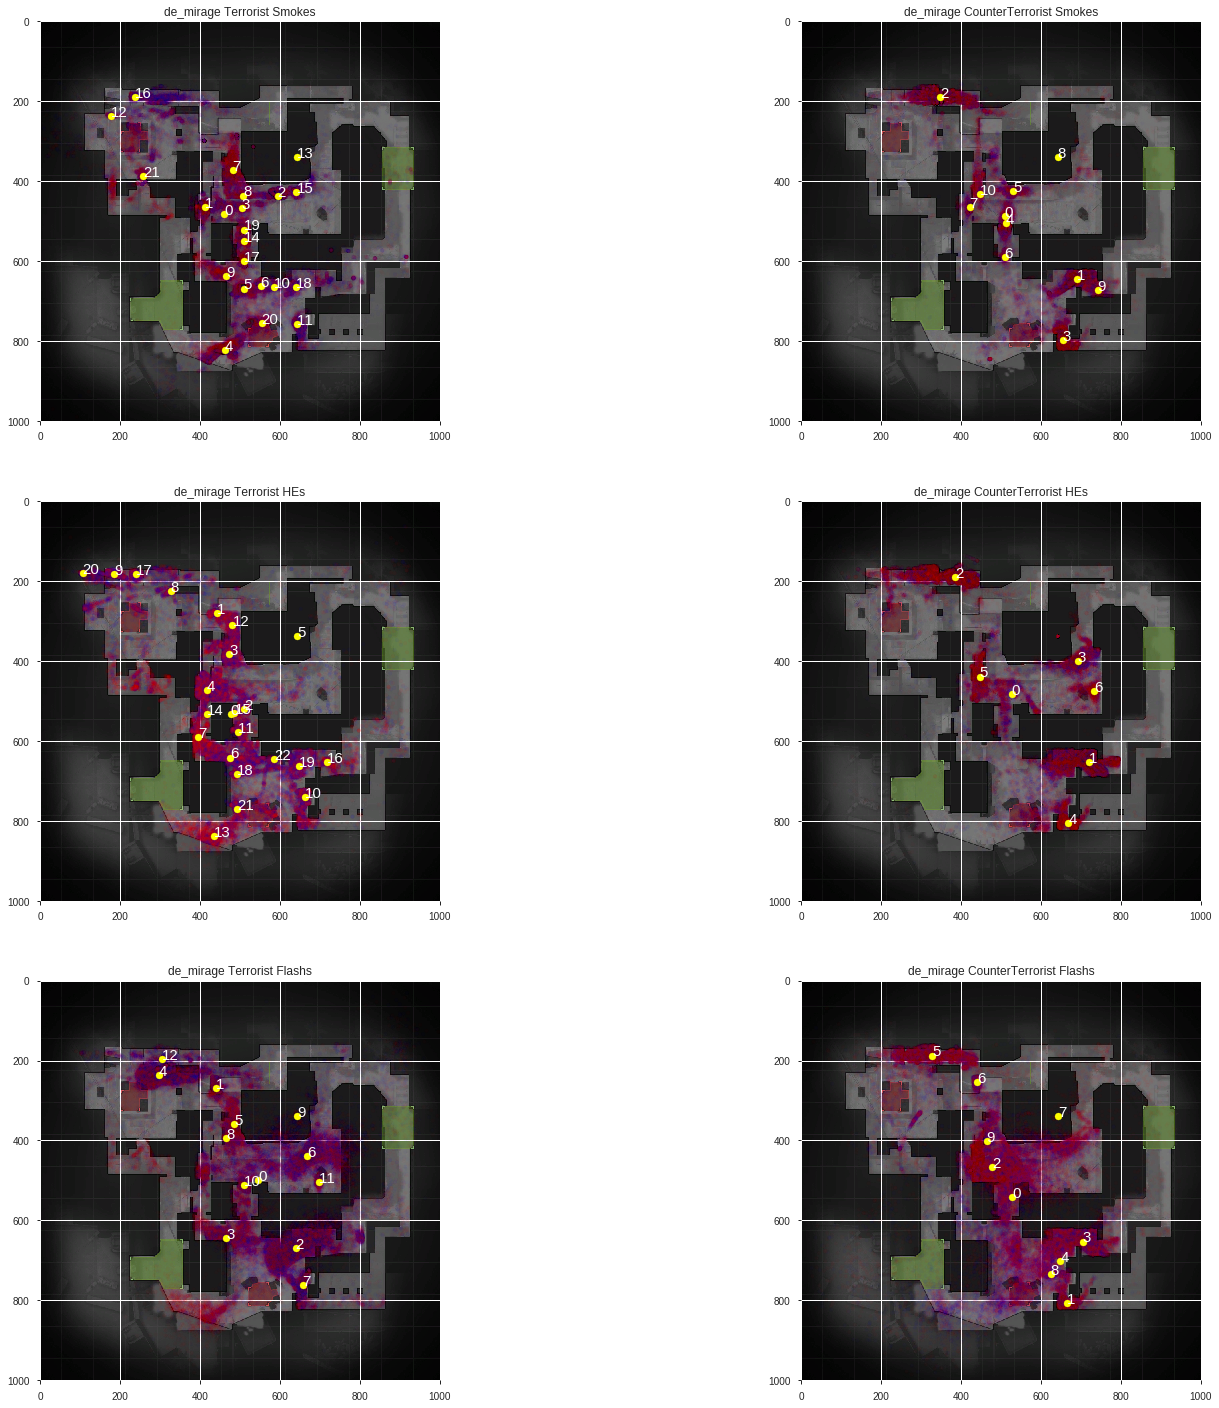

In [6]:
for map_name in ['de_mirage']:#['de_cache', 'de_cbble', 'de_dust2', 'de_inferno', 'de_mirage', 'de_overpass', 'de_train']:
    print(f"Calculating for {map_name}...")
    
    clustered_nade_df = cluster_utility(grenade_df, map_name=map_name, max_nades_to_process = 130000)
    perc_unclustered = 100 * len(clustered_nade_df[clustered_nade_df['cluster'] == -1]) / len(clustered_nade_df)
    print(f"{perc_unclustered}% of nades are unclustered")

    print(clustered_nade_df.columns)
    round_nade_df = pd.get_dummies(data=clustered_nade_df, columns=['cluster'])
    cluster_cols = [col for col in round_nade_df if col.startswith('cluster')]
    #print(t_mirage_df_one_hot[['att_side', 'nade'] + cols])
    round_nade_df = round_nade_df.drop(['round_type', 'winner_side'], axis=1).groupby(['file', 'round', 'att_side', 'nade'])
    round_nade_df = round_nade_df[cluster_cols].sum()
    round_nade_df = round_nade_df.unstack(level=['att_side', 'nade'])
    round_nade_df.columns = round_nade_df.columns.to_flat_index()
    round_nade_df = round_nade_df.reset_index()
    # Combine round win information
    meta_df = pd.read_csv('/kaggle/input/csgo-matchmaking-damage/esea_meta_demos.part1.csv')[['file', 'round', 'winner_side']]
    round_nade_df = pd.merge(round_nade_df, meta_df, how='left', left_on=['file','round'], right_on = ['file','round'])
    round_nade_df = round_nade_df.fillna(0)
    round_nade_df.columns = [tup if isinstance(tup, str) else f"{tup[2]}_{tup[1]}_{tup[0]}" for tup in round_nade_df.columns]
    # Remove clusters with no nades
    nade_counts = round_nade_df.drop(['file', 'round', 'winner_side'], axis=1).sum(axis=0)
    round_nade_df = round_nade_df.drop(nade_counts[nade_counts == 0].keys(), axis=1)
    round_nade_df.to_csv(f'{map_name}_clustered_nade_round_win.csv')
    gc.collect()


# Conclusion

## *Utility Usage Analysis on Mirage*
As seen from the above images/graphs of map Mirage (analysis carried out on Mirage as it is the most played map):

### *Terrorist Side (T-Side) Utility Usage*
On the T-side, utility plays a crucial role in gaining map control, isolating defenders, and securing bomb plants. The most common area where smokes are deployed is Mid, as controlling this part of the map allows for easier rotations and site executions. Among all smoke placements, the Connector smoke is the most frequently used (19 times), as it disrupts CT rotations from Mid to A or B and allows T-side players to take control of Catwalk or move into Jungle undetected.

*Other important smoke placements include*:

* Window Smoke – Blocks the vision of the CT AWP/sniper holding Mid from the Window position, allowing Ts to take Mid control without being exposed.
* Short (Catwalk) Smoke – Prevents CTs from holding Mid aggressively from Short, making it easier for Ts to progress toward Ladder Room or B-Site.
* Jungle and Stairs Smokes – Key smokes during an A-site execution, cutting off defender vision from Jungle and Stairs, enabling a safer site entry.
* B-Market and Arch Smokes – Used in B-site takes, preventing CTs from retaking the site from Market and making post-plant positioning stronger for Ts.

*In contrast, HE grenades (HGs) are primarily used to clear common CT hiding spots. The most frequent HE grenade placements include*:

* Triple Box on A-Site – A common CT position where defenders play to stop an A push.
* Bench on B-Site – Used to clear out potential defenders hiding near the Bombsite.
* Van on B-Site – Helps to clear out aggressive CTs who may be holding a close angle.
* Underpass/Mid Boost – Ts throw HEs to deal early damage to CTs attempting to contest Mid.

*Molotovs are essential for forcing CTs out of strong defensive positions. The most commonly used Molotov placements for T-side include*:

* Van on B-Site – Used to flush out CTs playing close.
* Default Plant on A-Site – Prevents CTs from defusing the bomb if they attempt a retake.
* Under Balcony on A-Site – A key position where CTs often hide; Molotovs force them out or deal heavy damage.
* Short (Catwalk) – To clear aggressive CTs holding angles near Ladder Room.

*Flashbangs are critical for both site entry and post-plant defense. Ts often throw flashes to blind CT defenders before executing onto a site. Some of the most common T-side flash placements include*:

* Jungle and CT Spawn Flashes – Used when executing an A-Site take, blinding defenders in Jungle, Stairs, and CT spawn.
* Market and Short Flashes – During a B execute, these flashes help T-side entry fraggers take control of Market and Catwalk.
* Mid Flashes – Used to blind Window, Connector, or Short players before taking Mid control.

By effectively utilizing these grenades, the T-side can isolate defenders, gain site control, and increase their chances of securing a round victory.



## *Counter-Terrorist Side (CT-Side) Utility Usage*
=====================================================
On the CT-side, utility is mainly used to delay enemy pushes, regain control of lost map areas, and execute successful retakes. Smokes are crucial in limiting T-side vision and denying key areas. 

### *The most common CT smokes include*:

* Window Smoke (Self-Throw) – Often used by CTs to maintain control of Mid and prevent early T-side aggression.
* Mid-to-Short Smoke – A defensive smoke thrown by a Short player to stop a fast Mid-to-B split.
* A-Ramp and Palace Smokes – Used to slow down A executes by blocking vision and forcing T-side players to use additional utility.
* B-Apps Smoke – Used to prevent a fast rush into B-Site, forcing Ts to wait or execute with flashes.
* Long Smoke – Used to delay T-side executes and prevent them from getting a strong angle on th

### *Molotovs are a key defensive tool for CTs, helping delay pushes and forcing Ts into unfavorable fights. The most common Molotov placements include*:

* A-Ramp Molotov – Prevents an early A rush by forcing Ts to wait or take damage.
* Palace Molotov – Stops Ts from pushing out of Palace quickly.
* B-Apps Molotov – Slows down or completely halts a B rush by forcing Ts back.
* Mid Window Molotov – Occasionally used to deny early Mid control to Ts.

### *HE grenades are mostly used to deal early damage or clear common entry points. CTs typically throw HEs at*:

* Top Mid – To chip away at T-side players attempting to take Mid control.
* A-Main and Palace – To damage Ts preparing for an A hit.
* B-Apps – Used when CTs expect a B rush, dealing heavy damage to grouped-up players.

### *Flashbangs are vital for both defensive holds and aggressive plays. Common CT-side flashes include*:

* Mid Window Flash – Used by the Window player to peek Mid safely.
* Pop Flashes for A-Ramp and Palace – Defensive flashes thrown from Jungle or CT spawn to blind Ts attempting to enter the site.
* Market Retake Flash – Used when retaking B, blinding Ts holding angles inside the site.
* Short and Ladder Room Flashes – Helps the Mid or Short player contest control.

During retakes, CTs rely heavily on flashes and smokes to regain site control. A well-placed CT smoke on the bomb during a retake can force Ts out of post-plant positions, making it easier to defuse.

By effectively using their utility, CTs can slow down T-side executes, force Ts into unfavorable fights, and increase their chances of winning rounds, whether by defending the sites or executing successful retakes.